In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

216         //We init them to nan to make sure we catch more debug case.
217         cudaMemset(rval, 0xFF, size);
218         //printf("MEMSET\n");
219     }
220     #if PRINT_FREE_MALLOC
221         fprintf(stderr, "device malloc %p of size %d\n", rval, size);
222     #endif
223     return rval;
224 }
225 
226 int device_free(void *ptr)
227 {
228     #if PRECHECK_ERROR
229         cudaThreadSynchronize();
230         cudaError_t prevError = cudaGetLastError();
231         if (cudaSuccess != prevError)
232         {
233             fprintf(stderr,
234                     "Error existed before calling device_free. %s\n",
235                     cudaGetErrorString(prevError)
236                     );
237         }
238     #endif
239     #if PRINT_FREE_MALLOC
240         size_t free = 0, total = 0;
241         cudaError_t err2 = cudaMemGetInfo(&free, &total);
242         if (err2 != cudaSuccess){
243             cudaGetLastError();
244             fprintf(stderr,
245                    

426             rval = -1;
427         }
428         self->dev_structure = NULL;
429     }
430     if (self->host_structure)
431     {
432         free(self->host_structure);
433         self->host_structure = NULL;
434     }
435     self->nd = -1;
436     Py_XDECREF(self->base);
437     self->base = NULL;
438     return rval;
439 }
440 
441 
442 //make the rightmost coords change fastest
443 //TODO: why does a downward for-loop not work????
444 //TODO: use the log2_dims and driver code to remove / and %
445 //TODO: skip the last division (when d == 0)
446 #define decl_k_elemwise_unary_rowmajor(name, F) \
447 __global__ void name (unsigned int numEls,  \
448         unsigned int nd, \
449         const int * dim,  \
450         const float * a_data, const int * a_str, \
451         float * z_data, const int * z_str) \
452 { \
453     const unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x; \
454     const unsigned int numThreads = blockDim.x * gridDim.x; \
455  \
456     for (un

651 // but this naming is very weird, makes it look like a macro
652 // we should figure out the correct convention and change to that
653 PyObject* CudaNdarray_ZEROS(int n, int * dims)
654 {
655 
656     size_t total_elements = 1;
657 
658     for(size_t i=0;i<n;i++){
659         // Detect overflow on unsigned integer
660         if (dims[i] != 0 && total_elements > (SIZE_MAX / dims[i])) {
661             PyErr_Format(PyExc_RuntimeError,
662                          "Can't store in size_t for the bytes requested %llu * %llu",
663                          (unsigned long long)total_elements,
664                          (unsigned long long)dims[i]);
665             return NULL;
666         }
667         total_elements*=dims[i];
668     }
669 
670     // total_elements now contains the size of the array, in reals
671     if (total_elements > (SIZE_MAX / sizeof(real))){
672         PyErr_Format(PyExc_RuntimeError,
673                      "Can't store in size_t for the bytes requested %ll

895 // TODO: make it return a view when the strides allow it even if it is not
896 //       c contiguous
897 PyObject * CudaNdarray_Reshape(CudaNdarray * self, PyObject * shape)
898 {
899     if(!CudaNdarray_is_c_contiguous(self))
900     {
901         // allocate new space
902         //TODO: test to see if we can re-use old one and take a new param to
903         //  use this
904         CudaNdarray* rval = (CudaNdarray*) CudaNdarray_Copy(self);
905         if (!rval)
906         {
907             return NULL;
908         }
909 
910         CudaNdarray* ret = (CudaNdarray*) CudaNdarray_Reshape(rval, shape);
911         Py_XDECREF(rval);
912         return (PyObject*)ret;
913     }
914 
915     // check shape tuple
916     unsigned int rval_nd;
917     unsigned int * rval_dims;
918     size_t rval_size = 1;
919 
920     if (PyTuple_Check(shape)){
921         // copy shape to integer array
922         rval_nd = PyTuple_Size(shape);
923     }else if (PyInt_Check(shape)){
924         rva

1096         } else {
1097             // Keep the refcount consistent
1098             Py_INCREF(indices_obj);
1099         }
1100         PyArray_Descr* float32_descr = PyArray_DescrFromType(NPY_FLOAT32);
1101         PyObject * indices_float32 = NULL;
1102         indices_float32 = PyArray_View((PyArrayObject*)indices_obj,
1103                                                   float32_descr, NULL);
1104         if (verbose) printf("ndarray indices\n");
1105         if (!indices_float32) {
1106             Py_DECREF(indices_obj);
1107             return NULL;
1108         }
1109 
1110         indices = (CudaNdarray*) CudaNdarray_New();
1111         if (verbose) printf("\nndarray after new\n");
1112         if (! indices){
1113             Py_DECREF(indices_obj);
1114             Py_DECREF(indices_float32);
1115             return NULL;
1116         }
1117         if (CudaNdarray_CopyFromArray(indices,
1118                                       (PyArrayObject *)indices_float32)){
1119

1292             {
1293                 int ty = std::min(CudaNdarray_HOST_DIMS(out)[2], max_threads);
1294                 int tx = std::min(CudaNdarray_HOST_DIMS(out)[1], max_threads / ty);
1295                 dim3 n_threads(tx, ty, 1);
1296                 if (verbose)
1297                     printf("cudaGetLastError=%d, nd=%d"
1298                            " kernel config: (n_blocks.x=%d, n_blocks.y=%d,"
1299                            " n_threads.x=%i, n_threads.y=%i)\n",
1300                            cudaGetLastError(), self->nd,
1301                            n_blocks.x, n_blocks.y, n_threads.x, n_threads.y);
1302                 k3<<<n_blocks, n_threads>>>(
1303                         dims[0], //dimensions
1304                         dims[1],
1305                         dims[2],
1306                         (npy_int64*) CudaNdarray_DEV_DATA(indices),
1307                         CudaNdarray_DEV_DATA(out),
1308                         CudaNdarray_HOST_STRIDES(out)[0], 

1492     CudaNdarray * other = (CudaNdarray *)py_other;
1493     if(!CudaNdarray_is_c_contiguous(self) || !CudaNdarray_is_c_contiguous(other)){
1494         PyErr_SetString(PyExc_TypeError, "We have implementet only the c_contiguous version for now.");
1495         return NULL;
1496     }
1497 
1498     //standard elemwise size checks
1499     if (self->nd != other->nd)
1500     {
1501         PyErr_SetString(PyExc_TypeError, "CudaNdarray_add: need same number of dims");
1502         return NULL;
1503     }
1504     //standard elemwise dim checks
1505     unsigned int size = 1;
1506     for (int i = 0; i< self->nd; ++i)
1507     {
1508         if (CudaNdarray_HOST_DIMS(self)[i] != CudaNdarray_HOST_DIMS(other)[i])
1509         {
1510             PyErr_SetString(PyExc_TypeError, "need same dimensions");
1511             return NULL;
1512         }
1513         size *= (unsigned int) CudaNdarray_HOST_DIMS(self)[i];
1514     }
1515     CudaNdarray * rval = (CudaNdarray *)CudaNdarray_New();

1671         case IADD:
1672             k3 = k_ielem_3<IADD>;
1673             k4 = k_ielem_4<IADD>;
1674             k6 = k_ielem_6<IADD>;
1675             break;
1676         case IDIV:
1677             k3 = k_ielem_3<IDIV>;
1678             k4 = k_ielem_4<IDIV>;
1679             k6 = k_ielem_6<IDIV>;
1680             break;
1681         case CPY:
1682             k3 = k_ielem_3<CPY>;
1683             k4 = k_ielem_4<CPY>;
1684             k6 = k_ielem_6<CPY>;
1685             break;
1686         default:
1687             assert (0);
1688             PyErr_Format(
1689                 PyExc_TypeError,
1690                 "CudaNdarray_inplace_elemwise invalid fct_nb (%i).",
1691                 (int)fct_nb);
1692             return -1;
1693     }
1694     if (!CudaNdarray_Check(py_self)) {
1695         PyErr_SetString(
1696             PyExc_TypeError,
1697             "CudaNdarray_inplace_elemwise need a CudaNdarray on left");
1698         return -1;
1699     }
1700     CudaNdarray 

1879                 CNDA_THREAD_SYNC;
1880                 cudaError_t err = cudaGetLastError();
1881                 if (cudaSuccess != err)
1882                 {
1883                     PyErr_Format(
1884                         PyExc_RuntimeError,
1885                         "CudaNdarray_inplace_elemwise case2: Cuda error: %s: %s.\n",
1886                         "k3",
1887                         cudaGetErrorString(err));
1888                     Py_XDECREF(new_other);
1889                     return -1;
1890                 }
1891             }
1892             break;
1893         case 3:
1894             {
1895                 //TODO:  Dimshuffle so that at least one of the arrays
1896                 //       has a contiguous dimension on the thread idx.
1897                 dim3 n_blocks(
1898                         std::min(
1899                             CudaNdarray_HOST_DIMS(self)[0],
1900                             NUM_VECTOR_OP_BLOCKS),
1901                        

2041                 //    n_blocks.z /= 2;
2042                 n_blocks.z = 1;
2043                 dim3 n_threads(
2044                         std::min(
2045                             CudaNdarray_HOST_DIMS(self)[3],
2046                             NUM_VECTOR_OP_THREADS_PER_BLOCK)
2047                     //TODO: DON'T YOU NEED TO PUT DIMS[4] in here???
2048                     //TODO: DON'T YOU NEED TO PUT DIMS[5] in here???
2049                             );
2050                 k6<<<n_blocks, n_threads>>>(
2051                         CudaNdarray_HOST_DIMS(self)[0],
2052                         CudaNdarray_HOST_DIMS(self)[1],
2053                         CudaNdarray_HOST_DIMS(self)[2],
2054                         CudaNdarray_HOST_DIMS(self)[3],
2055                         CudaNdarray_HOST_DIMS(self)[4],
2056                         CudaNdarray_HOST_DIMS(self)[5],
2057                         CudaNdarray_DEV_DATA(self),
2058                         CudaNdarray_HOST_STRIDES(s

2231 /////////////////////
2232 // Mapping protocol
2233 /////////////////////
2234 
2235 // Will by called by __len__ in Python
2236 static Py_ssize_t
2237 CudaNdarray_len(PyObject * py_self)
2238 {
2239     CudaNdarray * self = (CudaNdarray*) py_self;
2240     if (self->nd <= 0)
2241     {
2242         return (Py_ssize_t) 0;
2243     }
2244     else
2245     {
2246         return (Py_ssize_t) CudaNdarray_HOST_DIMS(self)[0];
2247     }
2248 }
2249 
2250 // Will by called by __getitem__ in Python
2251 PyObject *
2252 CudaNdarray_Subscript(PyObject * py_self, PyObject * key)
2253 {
2254     int verbose = 0;
2255     if (verbose) fprintf(stderr, "Subscript .... \n");
2256     CudaNdarray * self = (CudaNdarray*) py_self;
2257     PyObject * py_rval = NULL;
2258     CudaNdarray * rval = NULL;
2259     PyObject * intobj = NULL;
2260 
2261     //PyObject_Print(key, stderr, 0);
2262 
2263     if (key == Py_Ellipsis)
2264     {
2265         Py_INCREF(py_self);
2266         return py_self;
2267

2441                     {
2442                         std::cerr << "start " << start << "\n";
2443                         std::cerr << "stop " << stop << "\n";
2444                         std::cerr << "step " << step << "\n";
2445                         std::cerr << "slen " << slen << "\n";
2446                     }
2447                     ++rval_d;
2448                 }
2449                 else if ((intobj=PyNumber_Int(key_d)))
2450                 {
2451                     assert(PyArray_IsAnyScalar(key_d));
2452                     int d_idx = PyInt_AsLong(intobj);
2453                     Py_DECREF(intobj);
2454                     intobj = NULL;
2455                     int d_dim = CudaNdarray_HOST_DIMS(self)[d];
2456 
2457                     if ((d_idx >= 0) && (d_idx < d_dim))
2458                     {
2459                         //normal indexing
2460                         rval->devdata += d_idx * CudaNdarray_HOST_STRIDES(self)[d];
2461                     }
2462

2635         if (verbose)
2636             fprintf(stderr, "CudaNdarray_setitem error end\n");
2637         return -1;
2638     }
2639 
2640     assert (rval->base == baseSavedForComparison);
2641     assert (rval->dev_structure_fresh);
2642 
2643     // Clean up locally-created references
2644     Py_DECREF(rval);
2645     Py_XDECREF(new_value);
2646 
2647     return 0;
2648 }
2649 
2650 
2651 PyMappingMethods CudaNdarrayMappingMethods = {
2652     CudaNdarray_len, //lenfunc mp_length;               __len__
2653     CudaNdarray_Subscript, //binaryfunc mp_subscript;   __getitem__
2654     CudaNdarray_setitem //objobjargproc mp_ass_subscript;                __setitem__
2655 };
2656 
2657 ////////////////////
2658 //
2659 ////////////////////
2660 
2661 static PyObject *
2662 CudaNdarray_get_shape(CudaNdarray *self, void *closure)
2663 {
2664     if (self->nd < 0)
2665     {
2666         PyErr_SetString(PyExc_ValueError, "CudaNdarray not initialized");
2667         return NULL;

2806    

2995     return tuple;
2996 }
2997 #endif
2998 
2999 static PyGetSetDef CudaNdarray_getset[] = {
3000     {"shape",
3001         (getter)CudaNdarray_get_shape,
3002         (setter)CudaNdarray_set_shape,
3003         "shape of this ndarray (tuple)",
3004         NULL},
3005     {"_strides",
3006         (getter)CudaNdarray_get_strides,
3007         (setter)CudaNdarray_set_strides,
3008         "data pointer strides (in elements)",
3009         NULL},
3010     {"strides",
3011         (getter)CudaNdarray_get_strides,
3012         (setter)CudaNdarray_set_strides,
3013         "data pointer strides (in elements)",
3014         NULL},
3015     //gpudata is needed to allow calling pycuda fct with CudaNdarray input.
3016     {"gpudata",
3017         (getter)CudaNdarray_get_dev_data,
3018         NULL,
3019         "device data pointer",
3020         NULL},
3021     {"_dev_data",
3022         (getter)CudaNdarray_get_dev_data,
3023         (setter)CudaNdarray_set_dev_data,
3024         "device

3382         PyObject * idx = PyLong_FromLong(i);
3383         if (idx == NULL)
3384         {
3385             PyErr_SetString(PyExc_Exception, "CudaNdarray_from_gpu_pointer: Couldn't make long object to loop over list/tuple");
3386             return NULL;
3387         }
3388         PyObject* dim_ = PyObject_GetItem(shapes, idx);
3389         PyObject* strd_ = PyObject_GetItem(strides, idx);
3390         if (!PyInt_Check(dim_))
3391         {
3392             PyErr_Format(PyExc_Exception, "CudaNdarray_from_gpu_pointer: shapes[%d] is not an int", i);
3393             return NULL;
3394         }
3395         if (!PyInt_Check(strd_))
3396         {
3397             PyErr_Format(PyExc_Exception, "CudaNdarray_from_gpu_pointer: strides[%d] is not an int", i);
3398             return NULL;
3399         }
3400         int dim = PyInt_AsLong(dim_);
3401         int strd = PyInt_AsLong(strd_);
3402         CudaNdarray_set_stride((CudaNdarray *)rval, i, strd);
3403         CudaNdarray_set_dim(

3579     {"active_device_number", CudaNdarray_active_device_number, METH_VARARGS, "Get the number of the active device."},
3580     {"gpu_shutdown", CudaNdarray_gpu_shutdown, METH_VARARGS, "Shut down the gpu."},
3581     {"device_properties", GetDeviceProperties, METH_VARARGS, "Return a dictionary with the device properties."},
3582     {"mem_info", GetDeviceMemInfo, METH_NOARGS, "Return a tuple with the free and total memory on the gpu in bytes."},
3583 #if COMPUTE_GPU_MEM_USED
3584     {"theano_allocated", GetTheanoAllocInfo, METH_NOARGS, "Return the size in bytes of memory Theano currently have allocated on the gpu."},
3585 #endif
3586     {"ptr_int_size", CudaNdarray_ptr_int_size, METH_VARARGS, "Return a tuple with the size of gpu pointer, cpu pointer and int in bytes."},
3587     {"filter", filter, METH_VARARGS, "filter(obj, broadcastable, strict, storage) returns a CudaNdarray initialized to obj if it matches the constraints of broadcastable.  strict=True prevents any numeric cas

3803                      (long long)py_src_size,
3804                      py_src_data,
3805                      self->devdata);
3806         Py_DECREF(py_src);
3807         return -1;
3808     }
3809     Py_DECREF(py_src);
3810     return 0;
3811 }
3812 
3813 PyObject *
3814 CudaNdarray_new_nd(int nd)
3815 {
3816     CudaNdarray * rval = (CudaNdarray*) CudaNdarray_New();
3817     if (!rval || CudaNdarray_set_nd(rval, nd))
3818     {
3819         Py_XDECREF(rval);
3820         rval = NULL;
3821     }
3822     return (PyObject *) rval;
3823 }
3824 
3825 
3826 /**
3827  * Initialize 'self' as a view of 'base', with memory storage 'data'
3828  */
3829 
3830 int CudaNdarray_set_device_data(CudaNdarray * self, float * data, PyObject * base)
3831 {
3832     if (self->data_allocated)
3833     {
3834         assert(self->devdata);
3835         if (device_free(self->devdata))
3836         {
3837             self->devdata = NULL;
3838             self->data_allocated = 0;
3839             retu

4054                                             CudaNdarray_HOST_STRIDES(self)[1],
4055                                             CudaNdarray_HOST_STRIDES(self)[2],
4056                                             CudaNdarray_HOST_STRIDES(self)[3]
4057                                             );
4058                 CNDA_THREAD_SYNC;
4059                 cudaError_t err = cudaGetLastError();
4060                 if( cudaSuccess != err)
4061                 {
4062                     PyErr_Format(PyExc_RuntimeError,
4063                                  "Cuda error: %s: %s.",
4064                                  "k_copy_4d",
4065                                  cudaGetErrorString(err));
4066                     Py_XDECREF(new_other);
4067                     return -1;
4068                 }
4069             }; break;
4070         default:
4071             {
4072                 cudaError_t err = cudaGetLastError();
4073                 if(cudaSuccess != err){
4074              

4227     // a stride of 0 as a 'unit' stride because gemm will never use it.
4228     // If a dimension is 0, its stride will not be used either, so we can
4229     // consider it a 'unit' stride too.
4230     int unit = 0;
4231     if (CudaNdarray_HOST_STRIDES(A)[1] == 1 || CudaNdarray_HOST_DIMS(A)[1] <= 1) {
4232         unit |= (0x0 << 8);
4233     } else if (CudaNdarray_HOST_STRIDES(A)[0] == 1 || CudaNdarray_HOST_DIMS(A)[0] <= 1) {
4234         unit |= (0x1 << 8);
4235     } else {
4236         unit |= (0x2 << 8);
4237     }
4238     if (CudaNdarray_HOST_STRIDES(B)[1] == 1 || CudaNdarray_HOST_DIMS(B)[1] <= 1) {
4239         unit |= (0x0 << 4);
4240     } else if (CudaNdarray_HOST_STRIDES(B)[0] == 1 || CudaNdarray_HOST_DIMS(B)[0] <= 1) {
4241         unit |= (0x1 << 4);
4242     } else {
4243         unit |= (0x2 << 4);
4244     }
4245     if (CudaNdarray_HOST_STRIDES(C)[1] == 1 || CudaNdarray_HOST_DIMS(C)[1] <= 1) {
4246         unit |= (0x0 << 0);
4247     } else if (CudaNdarray_H

4538                                                  : CudaNdarray_HOST_DIMS(A)[1];
4539     int sa_1 = (CudaNdarray_HOST_DIMS(A)[1] > 1) ? CudaNdarray_HOST_STRIDES(A)[1]
4540                                                  : CudaNdarray_HOST_DIMS(A)[0];
4541 
4542     // This is important because we can end up not calling Sger at all
4543     cublasStatus_t err = CUBLAS_STATUS_SUCCESS;
4544     if(CudaNdarray_SIZE(A)){
4545         // If A is in col-major
4546         if ((CudaNdarray_HOST_DIMS(A)[0] <= 1)
4547             || ((CudaNdarray_HOST_STRIDES(A)[0] == 1)
4548                 && (CudaNdarray_HOST_STRIDES(A)[1] > 0)))
4549         {
4550             err = cublasSger(handle, CudaNdarray_HOST_DIMS(x)[0], CudaNdarray_HOST_DIMS(y)[0], &alpha,
4551                        CudaNdarray_DEV_DATA(x), x_strides,
4552                        CudaNdarray_DEV_DATA(y), y_strides,
4553                        CudaNdarray_DEV_DATA(A), sa_1);
4554         }
4555         // Since Sger expects A 

5302                      cudaGetErrorString(err));
5303         return -1;
5304     }
5305     fprintf(fd, "CudaNdarray <%p, %p> nd=%i dev_structure_fresh=%d data_allocated=%d\n",
5306             self, self->devdata, self->nd, self->dev_structure_fresh, self->data_allocated);
5307     fprintf(fd, "\tHOST_DIMS:      ");
5308     for (int i = 0; i < self->nd; ++i)
5309     {
5310         fprintf(fd, "%i\t", CudaNdarray_HOST_DIMS(self)[i]);
5311     }
5312     fprintf(fd, "\n\tHOST_STRIDES: ");
5313     for (int i = 0; i < self->nd; ++i)
5314     {
5315         fprintf(fd, "%i\t", CudaNdarray_HOST_STRIDES(self)[i]);
5316     }
5317 
5318     if (self->dev_structure)
5319     {
5320         int data=0;
5321         fprintf(fd, "\n\tDEV_DIMS:      ");
5322         for (int i = 0; i < self->nd; ++i)
5323         {
5324             cublasGetVector(1, sizeof(int),
5325                             self->dev_structure+i, 1,
5326                             &data, 1);
5327             fprintf(f

nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc fatal   : Cannot find compiler 'cl.exe' in PATH

['nvcc', '-shared', '-O3', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"C:\\Anaconda3\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"C:\\Anaconda3\\lib\\site-packages\\numpy\\core\\include"', '-I"C:\\Anaconda3\\include"', '-I"C:\\Anaconda3\\lib\\site-packages\\theano\\gof"', '-L"C:\\Anaconda3\\libs"', '-L"C:\\Anaconda3"', '-o', 'C:\\Users\\hjunk\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.6.1-64\\cuda_ndarray\\cuda_ndarray.pyd', 'mod.cu', '-lcublas', '-lpython36', '-lcudart']


ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: ('nvcc return status', 1, 'for cmd', 'nvcc -shared -O3 -Xlinker /DEBUG -D HAVE_ROUND -m64 -Xcompiler -DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD -I"C:\\Anaconda3\\lib\\site-packages\\theano\\sandbox\\cuda" -I"C:\\Anaconda3\\lib\\site-packages\\numpy\\core\\include" -I"C:\\Anaconda3\\include" -I"C:\\Anaconda3\\lib\\site-packages\\theano\\gof" -L"C:\\Anaconda3\\libs" -L"C:\\Anaconda3" -o C:\\Users\\hjunk\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.6.1-64\\cuda_ndarray\\cuda_ndarray.pyd mod.cu -lcublas -lpython36 -lcudart')


In [28]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    # output 18개 1과 12개 0의 Sequence 3회 반복
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [29]:
len(data)

90

In [30]:
np.arange(len(N_samples))

array([0, 1, 2])

$\alpha$ ~ $HalfCauchy(\beta_\alpha)$

$\beta$ ~ $HalfCauchy(\beta_\beta)$

$\theta$ ~ $Beta(\alpha, \beta)$

$y$ ~ $Bernoulli(\theta)$

C:\Anaconda3\lib\site-packages\theano\tensor\basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -65.313: 100%|███████████████████████████████████████████████| 200000/200000 [00:17<00:00, 11517.20it/s]
Finished [100%]: Average ELBO = -65.283
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 207.52it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B4A0D93F98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002B4A3695CC0>]], dtype=object)

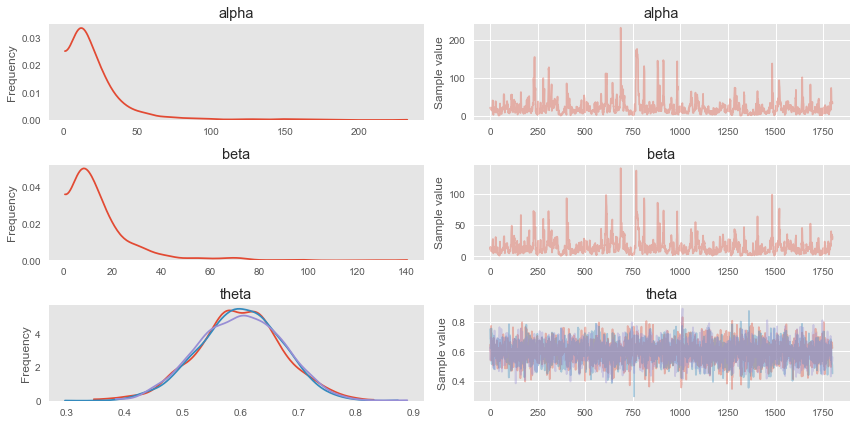

In [31]:
with pm.Model() as model_h:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(N_samples))
    
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)
    trace_j = pm.sample(2000)

chain_h = trace_j[200:]
pm.traceplot(chain_h)

## 여기서 말하는 Hierarchical은 hyperparameter 존재 유무..

### Shrinkage part

In [32]:
pm.df_summary(chain_h)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,23.707106,23.927016,1.369268,1.119427,63.331984
beta,15.845078,14.979019,0.869541,0.792642,43.050405
theta__0,0.598626,0.073972,0.001993,0.465250,0.756617
theta__1,0.598737,0.070647,0.002003,0.460142,0.733476
theta__2,0.599968,0.073051,0.001930,0.452569,0.729825


## 위 결과를 보면 mean estimation 값이 좀 이상함.

### 30개 중 18개가 정상인 sample case에 대해서는 대략 0.6 정도의 mean값이 나와야하는데, 0.52로 값이 축소되어 나옴

### 위와 같은 결과를 Hierarchical model에서의 Shrinkage라고 함. shared parameter인 hyper parameter를 사용하기 때문에, Model이 전체 output을 고려하여 분포를 생성하게 됨. 쉽게 말해 각기 다른 3개의 그룹에 대한 확률 변수를 구할 경우, 3개 그룹 전체의 특성으로 인한 보정이 이뤄진다는 것

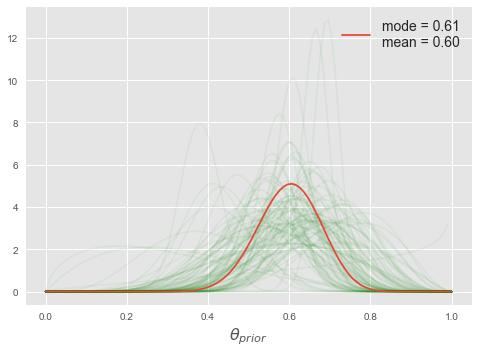

In [33]:
from scipy import stats
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(chain_h), size=100):
    pdf = stats.beta(chain_h['alpha'][i], chain_h['beta'][i]).pdf(x)
    plt.plot(x, pdf, 'g', alpha=0.05)
    
dist = stats.beta(chain_h['alpha'].mean(), chain_h['beta'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel("$\\theta_{prior}$", fontsize=16)